In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import os

di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/ice_to_rock'

NHALO = 4
IC_FILE = 'MOM_IC.nc'
PROG_FILE = 'prog.nc'
ICE_SHELF_FILE = '/INPUT/shelfX.nc'

In [59]:
### New shelf
def make_shelf(filename):
    
    new_shelf = nc.Dataset(filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    new_shelf["area"][:,:120] = 4000000 # ice
    #new_shelf["area"][:,60:120] = 4000000 # rock
    #new_shelf["area"][:,:60] = 0 # rock
    new_shelf["area"][:,120:] = 0
 
    bb4 = 333.2*np.ones(240)
    iip = 5
    for j in range(iip):
        bb4[120-j] = bb4[120-iip]*j/iip
    bb4[120:] = 0
    #bb4[:60] = 0 # rock
    new_shelf["thick"][:,:] = bb4

    new_shelf.close()    

In [60]:
### New topography
def make_topography(filename):
    
    new_topog = nc.Dataset(filename, "w", format="NETCDF4")
    new_topog.createDimension("ny", 40)
    new_topog.createDimension("nx", 240)
    new_topog.createVariable("depth","f8",("ny","nx"))

    new_topog["depth"][:,:60] =  290  #(rock=0/ice=290)
    new_topog["depth"][:,60:] =  720

    new_topog.close()

In [61]:
### new thickness file for THICKNESS_CONFIG="thickness_file"
def make_thickness_file(filename):
    
    ic = xr.open_dataset(di + '/' + IC_FILE)
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(di + "/INPUT/thickness.nc", "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()

In [43]:
!cat input.nml | tail

 
 &ocean_solo_nml
            months = 0
            date_init = 1,1,1,0,0,0
            days = 0
            hours = 0
            minutes = 0
            seconds = 600
            calendar = 'julian' /



In [44]:
!cat diag_table | head

"GOLD Experiment"
1 1 1 0 0 0
"prog",     300,"seconds",1,"days","Time"
"mom",     300,"seconds",1,"days","Time"
"forcing",     300,"seconds",1,"days","Time"
#"prog",     1,"hours",1,"days","Time"
#"mom",     1,"hours",1,"days","Time"
#"forcing",     1,"hours",1,"days","Time"
#"ave_prog", 5,"days",1,"days","Time",365,"days"
#"cont_%4yr_%3dy",     5,"days",1,"days","Time",365,"days"


In [ ]:
make_shelf(di + "/INPUT/shelfX.nc")
make_topography(di + "/INPUT/topogX.nc")

In [46]:
# Prepare axes for 3D plotting of ice shelf IC, topography etc
mic = xr.open_dataset(di + "/"+ IC_FILE)   # MOM6 output
LY, LX = mic.h.data[0].shape[1], mic.h.data[0].shape[2]
YY= np.arange(0, LY, 1)
XX = np.arange(0, LX, 1)
XX, YY = np.meshgrid(XX, YY)

mic.close()

(1, 40, 240)


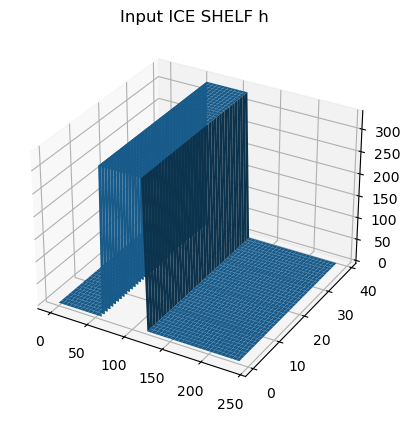

In [50]:
ms = xr.open_dataset(di + '/MOM_Shelf_IC.nc')   # MOM6 output
print(ms.h_shelf.data.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX, YY, ms.h_shelf.data[0])
plt.title("Input ICE SHELF h")
plt.show()

ms.close()

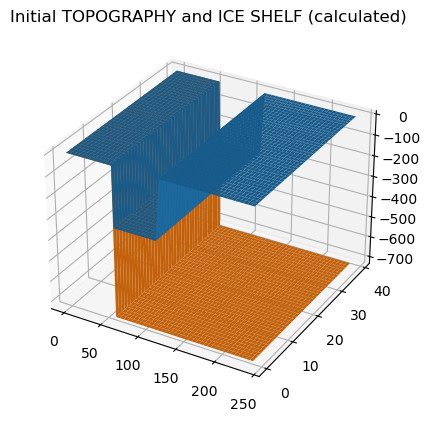

In [51]:
#bt = xr.open_dataset(di+'/deb_bathyT.nc') # works only for 1 core
#h0 = xr.open_dataset(di + '/after_ts_1_h.nc') # works only for 1 core
#ee = np.sum(h0.h.data,axis=0) - bt.bathyT.data
#print(ee.shape) # with halo

ic = xr.open_dataset(di + '/' + IC_FILE)
#mic=xr.open_dataset(di + '/' + IC_FILE)   # TODO: see if eta works
eta = ic.eta[0].data[0]
#pr = xr.open_dataset(di + '/' + PROG_FILE)
#ee2 = pr.e[0].data[0]
#bathyT = ee2 - np.sum(ic.h[0].data, axis=0)
bathyT = eta - np.sum(ic.h[0].data, axis=0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

#surf = ax.plot_surface(XX, YY, ee[NHALO:-NHALO,NHALO:-NHALO])
#topo = ax.plot_surface(XX, YY, -bt.bathyT.data[NHALO:-NHALO,NHALO:-NHALO])
#surf2 = ax.plot_surface(XX, YY, ee2)
surf2 = ax.plot_surface(XX, YY, eta)
topo2 = ax.plot_surface(XX, YY, bathyT)

plt.title("Initial TOPOGRAPHY and ICE SHELF (calculated)")
plt.show()

ic.close()
#mic.close()

### Plot output h,e,salt etc at chosen time

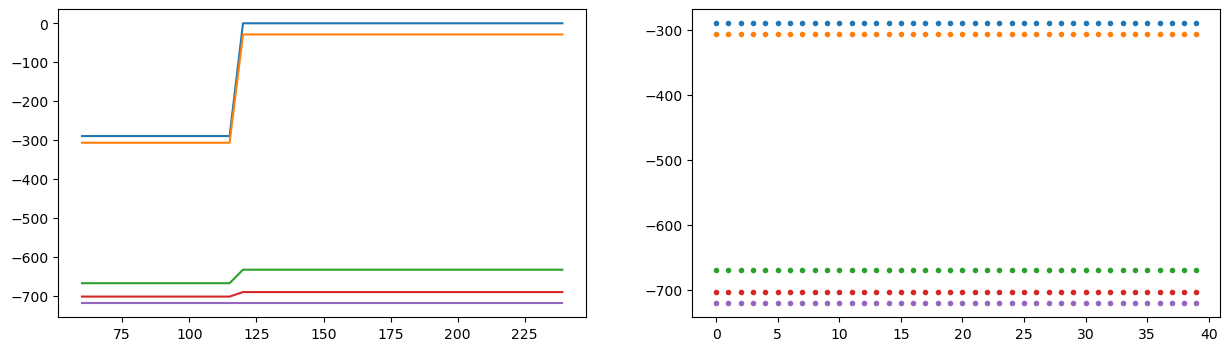

In [52]:
prog = xr.open_dataset(di + '/'+PROG_FILE)
     
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
tt=0; zz= 22; yy=0; xx=71; ll = [0,1,zz,-2,-1] # ll=[0,1,2,3,4,5,10,-3,-2,-1]
for zzz in ll:
    axes[0].plot(prog.e[tt][zzz].data[yy,:])
    axes[1].plot(prog.e[tt][zzz].data[:,xx],'.')

In [53]:
np.nanmin(prog.h[0].data)

17.198670498370067

ttt = -1; zzz = 0
plt.plot(prog.salt.data[ttt][zzz][yy,:])

In [54]:
print(np.nanmax(prog.u.data[-1]), np.nanmin(prog.u.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

3.8078821906720067e-06 -5.840074590578767e-07


In [55]:
print(np.nanmax(prog.v.data[-1]), np.nanmin(prog.v.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

2.917806025009906e-07 -2.917806025009906e-07


In [56]:
arr = prog.u.data[-1]
ind = np.unravel_index(np.nanargmax(arr),arr.shape)
print(arr[ind])
ind

3.8078821906720067e-06


(1, 0, 116)

In [57]:
np.nanmin(prog.e.data[0])

-720.0

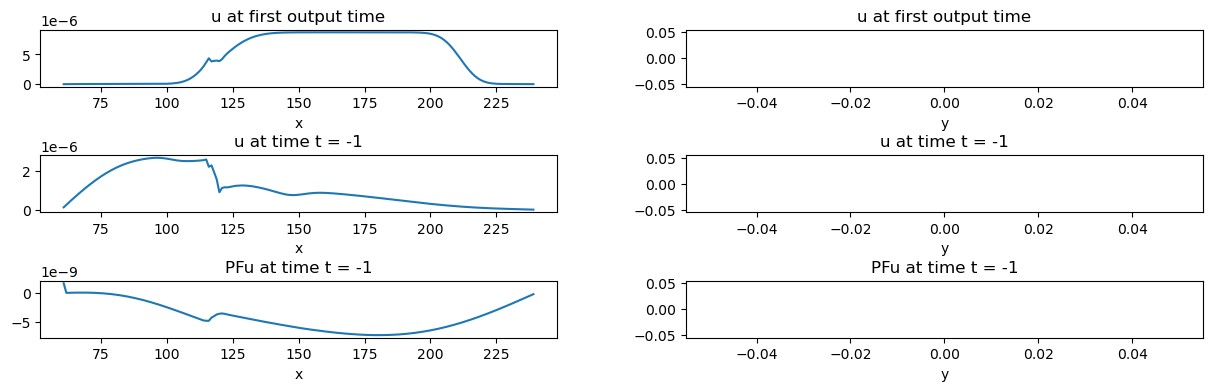

In [58]:
#aft = xr.open_dataset(di + '/after_ts_2_u.nc') # works only for 1 core, shows u after 1 time step
mo = xr.open_dataset(di + '/mom.nc')

fig,axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15,4))

tt=-1; zz=7; yy=0; xx=56
#axes[0,0].plot(aft.u.data[zzz,yy+NHALO,NHALO:-NHALO])
axes[0,0].plot(prog.u[0][zz].data[yy,:])
axes[0,0].set_xlabel("x")
axes[0,0].set_title("u at first output time") # depends on diag_table setting
#axes[0,1].plot(aft.u.data[zzz,NHALO:-NHALO,xx+NHALO],'o')
axes[0,1].plot(prog.u[0][zz].data[:,xx])
axes[0,1].set_xlabel("y")
axes[0,1].set_title("u at first output time") # depends on diag_table setting
axes[1,0].plot(prog.u[tt][zz].data[yy,:])
axes[1,0].set_xlabel("x")
axes[1,0].set_title("u at time t = {}".format(tt))
axes[1,1].plot(prog.u[tt][zz].data[:,xx])
axes[1,1].set_xlabel("y")
axes[1,1].set_title("u at time t = {}".format(tt))
axes[2,0].plot(mo.PFu[tt][zz].data[yy,:])
axes[2,0].set_xlabel("x")
axes[2,0].set_title("PFu at time t = {}".format(tt))
axes[2,1].plot(mo.PFu[tt][zz].data[:,xx])
axes[2,1].set_xlabel("y")
axes[2,1].set_title("PFu at time t = {}".format(tt))

plt.subplots_adjust(wspace = 0.25, hspace = 1.2)

mo.close()

### Make thickness file to use with THICKNESS_CONFIG (without applying salt adjustment first)
#### Use with HACK_MODE=True and REMAP_AFTER_INITIALIZATION=False
#### This is an alternative to ADJUST_SALT=True. It is MPI-safe!!!

### Make an "adjusted salt" file

#! Open files saved by MOM6 needed to adjust the salt 
bt=xr.open_dataset(di + "/deb_bathyT.nc") # topography file needed to calculate e
h=xr.open_dataset(di + '/after_ts_2_h.nc') # h file before the first time step, but after MOM6 remap
S=xr.open_dataset(di + '/before_finish_MOM_initialization_S.nc') # salt file produced by MOM6, which we want to adjust 

#! calculate e and then s as a linear function of e 
S_TOP = 33.8
S_BOTTOM = 34.55
MAXIMUM_DEPTH = 720.0
e=h.h.sum(axis=0).data-bt.bathyT.data
s=(e-h.h.data.cumsum(axis=0) + h.h.data/2)*(S_BOTTOM-S_TOP)/(-MAXIMUM_DEPTH) + S_TOP

#! fix the halo points
s[:,:NHALO,:NHALO]=0
s[:,:NHALO,-NHALO:]=0
s[:,-NHALO:,:NHALO]=0
s[:,-NHALO:,-NHALO:]=0

#! create new netcdf4 file for the adjusted salt based on the original salt file
nz, ny, nx = S.S.data.shape
new_salt = nc.Dataset(di + "/INPUT/adjustedS.nc", "w", format="NETCDF4")
new_salt.createDimension("nz", nz)
new_salt.createDimension("ny", ny)
new_salt.createDimension("nx", nx)
temp = new_salt.createVariable("S","f8",("nz","ny","nx"))
temp[:,:,:]=s
new_salt.close()

### Make new  topography and ice shelf files, if necessary

#! use ISOMIP ice shelf as model
old = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r")
print(old)

b3 = old.variables["thick"][19,:]
for i in range(240):
   b3[i]=350-350.0/125.0*i
b1 = np.maximum(b3, 50)

zero_position = np.where(b1==0)[0]
b2 = old.variables["area"][19,:]
b2[zero_position]=0 # Grosveld 2
#b2[:]=4000000.   # Grosveld 1

b5 = old.variables["area"][19,:]
for i in range(240):
   b5[i]=500+(700-500)/125.0*i
b4 = np.minimum(b5, 700)

plt.plot(b1)

#plt.plot(b3)
#plt.plot(bb3)
bb3[164]

#for ii in range(1,40,4):
#!    plt.plot(bb3 +(19.5-ii)**2*0.3)
    
#bb4 = np.zeros(240)

ii = 30
bb4 = bb3 +(19.5-ii)**2*0.3

iip = abs(20-ii)
for j in range(iip):
    bb4[164-j] = bb4[164-iip]*j/iip
    
bb4[164:] = 0
plt.plot(bb4)
plt.plot(bb3)

### New shelf: Cut the ISOMIP ice shelf in half

old_shelf = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r") #! use ISOMIP ice shelf as model
print(old_shelf)

thi = old_shelf.variables["thick"][:,:]
 
ar = old_shelf.variables["area"][:,:]

print(thi[:,120:].shape)

new_shelf = nc.Dataset(di + "/INPUT/shelfX.nc", "w", format="NETCDF4")
new_shelf.createDimension("ny", 40)
new_shelf.createDimension("nx", 120)
new_shelf.createVariable("thick","f8",("ny","nx"))

new_shelf.createVariable("area","f8",("ny","nx"))

new_shelf["area"][:,:] = ar[:,120:]
new_shelf["thick"][:,:] = thi[:,120:]

new_shelf.close()

ic = xr.open_dataset(di + '/MOM_IC.nc')
ic.h.data.shape

### New shelf: Make ISOMIP ice shelf half as massive

old_shelf = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r") #! use ISOMIP ice shelf as model
print(old_shelf)

thi = old_shelf.variables["thick"][:,:]
ar = old_shelf.variables["area"][:,:]

print(thi[:,120:].shape)

new_shelf = nc.Dataset(di + "/INPUT/shelfX.nc", "w", format="NETCDF4")
new_shelf.createDimension("ny", 40)
new_shelf.createDimension("nx", 240)
new_shelf.createVariable("thick","f8",("ny","nx"))

new_shelf.createVariable("area","f8",("ny","nx"))

new_shelf["area"][:,:] = ar
new_shelf["thick"][:,:] = thi/2

new_shelf.close()

In [28]:
### Turn ice into rock where valid
#bt = xr.open_dataset(di+'/deb_bathyT.nc') # works only for 1 core
#h0 = xr.open_dataset(di + '/after_ts_1_h.nc') # works only for 1 core
#ee = np.sum(h0.h.data,axis=0) - bt.bathyT.data
#print(ee.shape) # with halo

ice_shelf = xr.open_dataset(di + '/' + ICE_SHELF_FILE)
ic = xr.open_dataset(di + '/' + IC_FILE)
#pr = xr.open_dataset(di + '/' + PROG_FILE)
#ee2 = pr.e[0].data[0]
#mic=xr.open_dataset(di + '/' + IC_FILE)   # TODO: see if eta works
eta = ic.eta[0].data[0]
#bathyT = ee2 - np.sum(ic.h[0].data, axis=0)
bathyT = eta - np.sum(ic.h[0].data, axis=0)

#print(np.nanmin(ee[NHALO:-NHALO,NHALO:-NHALO]+bt.bathyT.data[NHALO:-NHALO,NHALO:-NHALO]))
print(np.nanmin(eta-bathyT))

new_shelf = nc.Dataset(di + "/INPUT/shelfX2.nc", "w", format="NETCDF4")
new_shelf.createDimension("ny", 40)
new_shelf.createDimension("nx", 240)
new_shelf.createVariable("thick","f8",("ny","nx"))
new_shelf.createVariable("area","f8",("ny","nx"))
#new_shelf["thick"][:,:] = np.where(ee2-bathyT<1e-2,[0],ice_shelf.thick)
new_shelf["thick"][:,:] = np.where(eta-bathyT<1e-2,[0],ice_shelf.thick)
#new_shelf["thick"][:,:] = np.where(
#    ee[NHALO:-NHALO,NHALO:-NHALO]+bt.bathyT.data[NHALO:-NHALO,NHALO:-NHALO]<1e-3,[0],ice_shelf.thick)
new_shelf.close()

new_topog = nc.Dataset(di + "/INPUT/topogX2.nc", "w", format="NETCDF4")
new_topog.createDimension("ny", 40)
new_topog.createDimension("nx", 240)
new_topog.createVariable("depth","f8",("ny","nx"))
new_topog["depth"][:,:] = np.where(eta-bathyT<1e-3,[0],-bathyT)
#new_topog["depth"][:,:] = np.where(ee2-bathyT<1e-3,[0],-bathyT)
#new_topog["depth"][:,:] = np.where(
#   ee[NHALO:-NHALO,NHALO:-NHALO]+bt.bathyT.data[NHALO:-NHALO,NHALO:-NHALO]<1e-3,[0],
#   bt.bathyT.data[NHALO:-NHALO,NHALO:-NHALO])
new_topog.close()

os.rename(di + "/INPUT/shelfX2.nc", di + "/INPUT/shelfX.nc")
os.rename(di + "/INPUT/topogX2.nc", di + "/INPUT/topogX.nc")

ice_shelf.close()
ic.close()
#mic.close()

2.4999735614983365e-09


plt.imshow(np.where(ee2-bathyT<1e-3,[0],bathyT))
plt.colorbar(shrink=0.5)

plt.imshow(np.where(ee2-bathyT<1e-3,[0],ice_shelf.thick))
plt.colorbar(shrink=0.5)

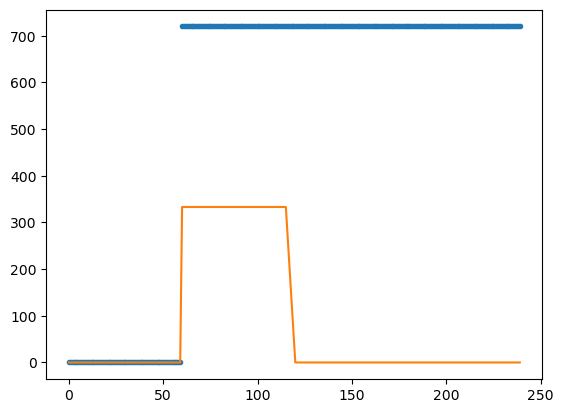

In [29]:
tp=xr.open_dataset(di + '/' + "/INPUT/topogX.nc")
sh=xr.open_dataset(di + '/' + "/INPUT/shelfX.nc")
plt.plot(tp.depth.data[0],'.')
plt.plot(sh.thick.data[0])
tp.close()
sh.close()